In [31]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import joblib
import pickle
import seaborn as sns
from utils.get_targets import get_first_threshold_bump, get_close_price_target
from stockstats import StockDataFrame
from matplotlib import pyplot as plt
import seaborn as sns
import optuna
import random
from tqdm import tqdm
from functools import reduce

from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
DATA_PATH = "./data/prices/TSLA_1minute_train.csv"
TEST_PATH = "./data/prices/TSLA_1minute_test.csv"
MODEL_PATH = "./tsla_trader_qc"

TEST_RATIO = 0.2
TIME_LAG = 15

In [3]:
def prepare_dataset(path: str) -> pd.DataFrame:
    data = pd.read_csv(DATA_PATH, index_col=0)
    data = data.join(pd.Series(get_close_price_target(data, TIME_LAG), name="target"))
    data.dropna(inplace=True)
    
    return data

In [4]:
data = prepare_dataset(DATA_PATH)
data

,volume,open,close,high,low,date,ticker,target
0,14965.0,159.524,159.40,159.524,159.400,2020-05-11 11:20:00,TSLA,0.9000
1,13155.0,159.272,159.30,159.380,159.272,2020-05-11 11:21:00,TSLA,1.1000
2,29320.0,159.264,159.30,159.300,159.132,2020-05-11 11:22:00,TSLA,1.1320
3,37080.0,159.242,159.00,159.402,158.860,2020-05-11 11:23:00,TSLA,1.2180
4,11630.0,159.200,159.36,159.400,159.200,2020-05-11 11:25:00,TSLA,0.6920
...,...,...,...,...,...,...,...,...
295524,1946.0,953.800,953.21,953.800,953.090,2021-12-15 14:25:00,TSLA,10.4000
295525,6061.0,953.690,952.26,953.690,952.260,2021-12-15 14:26:00,TSLA,9.9567
295526,3270.0,952.000,954.23,954.470,952.000,2021-12-15 14:27:00,TSLA,8.2700
295527,1720.0,953.120,953.20,953.320,953.120,2021-12-15 14:28:00,TSLA,12.0099


In [5]:
dates = data.date.apply(lambda date: pd.Timestamp(date))
print(f"С {dates.min()} по {dates.max()}")

С 2020-05-11 11:20:00 по 2021-12-15 14:29:00


In [6]:
train_df, test_df = train_test_split(data, test_size=TEST_RATIO, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
display(train_df)
display(test_df)

,volume,open,close,high,low,date,ticker,target
0,14965.0,159.5240,159.400,159.5240,159.400,2020-05-11 11:20:00,TSLA,0.9000
1,13155.0,159.2720,159.300,159.3800,159.272,2020-05-11 11:21:00,TSLA,1.1000
2,29320.0,159.2640,159.300,159.3000,159.132,2020-05-11 11:22:00,TSLA,1.1320
3,37080.0,159.2420,159.000,159.4020,158.860,2020-05-11 11:23:00,TSLA,1.2180
4,11630.0,159.2000,159.360,159.4000,159.200,2020-05-11 11:25:00,TSLA,0.6920
...,...,...,...,...,...,...,...,...
236418,55985.0,665.0000,664.530,665.0000,664.090,2021-08-17 15:03:00,TSLA,-0.6784
236419,72814.0,664.3900,663.560,664.3900,663.220,2021-08-17 15:04:00,TSLA,0.3158
236420,64558.0,663.6500,663.285,663.7399,662.910,2021-08-17 15:05:00,TSLA,-0.0851
236421,110748.0,663.1715,662.215,663.2300,662.120,2021-08-17 15:06:00,TSLA,1.0550


,volume,open,close,high,low,date,ticker,target
0,77538.0,663.060,663.0300,663.6200,662.84,2021-08-17 15:08:00,TSLA,-0.1000
1,42378.0,662.990,662.7800,663.1765,662.40,2021-08-17 15:09:00,TSLA,0.0300
2,128676.0,662.685,662.7700,662.7799,661.66,2021-08-17 15:10:00,TSLA,-0.0900
3,59285.0,662.860,662.1182,663.0000,662.08,2021-08-17 15:11:00,TSLA,0.5057
4,68082.0,662.140,663.5300,663.7700,661.84,2021-08-17 15:12:00,TSLA,-1.0300
...,...,...,...,...,...,...,...,...
59101,1946.0,953.800,953.2100,953.8000,953.09,2021-12-15 14:25:00,TSLA,10.4000
59102,6061.0,953.690,952.2600,953.6900,952.26,2021-12-15 14:26:00,TSLA,9.9567
59103,3270.0,952.000,954.2300,954.4700,952.00,2021-12-15 14:27:00,TSLA,8.2700
59104,1720.0,953.120,953.2000,953.3200,953.12,2021-12-15 14:28:00,TSLA,12.0099


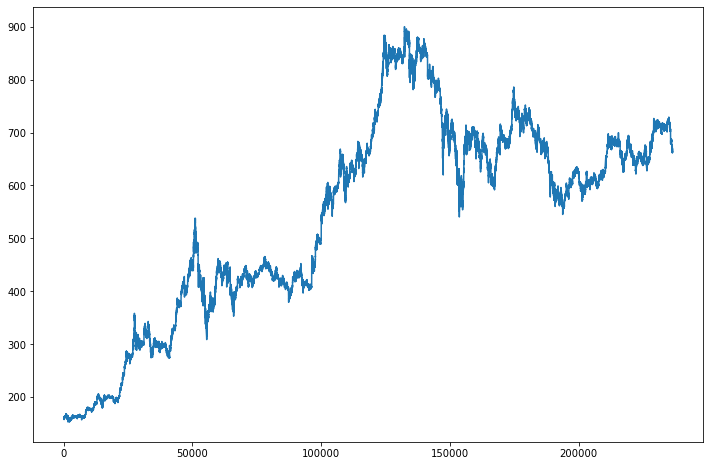

In [7]:
plt.figure(figsize=(12, 8))

plt.plot(train_df["close"])

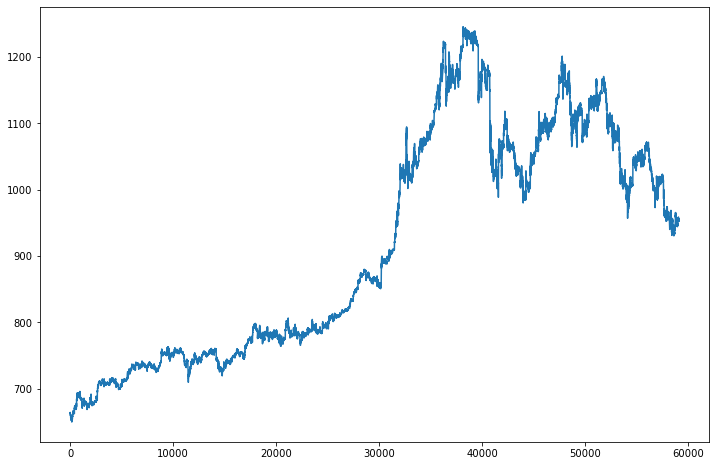

In [8]:
plt.figure(figsize=(12, 8))

plt.plot(test_df["close"])

In [9]:
dates = test_df.date.apply(lambda date: pd.Timestamp(date))
print(f"С {dates.min()} по {dates.max()}")

С 2021-08-17 15:08:00 по 2021-12-15 14:29:00


In [17]:
def get_features(dataset: pd.DataFrame, train: bool = True, indicators = None) -> pd.DataFrame:
    
    initial_features = ["open", "close", "low", "high", "volume"]
    result_dataset = StockDataFrame(dataset.copy())
    
    if indicators is None:
        indicators = [
            "change", "change_10_mstd", "change_10_ema", "change_20_mstd", "change_20_ema",
            "volume_10_mstd", "volume_10_ema", "volume_20_mstd", "volume_20_ema",
            "close_-20_d",
            "rsi", "rsi_10_mstd", "rsi_10_ema", "rsi_20_mstd", "rsi_20_ema", "rsi_40_mstd", "rsi_40_ema",
            "stochrsi_6", "stochrsi_10_mstd", "stochrsi_10_ema", "stochrsi_20_mstd", "stochrsi_20_ema",
            "wt1", "wt1_10_mstd", "wt1_10_ema", "wt1_20_mstd", "wt1_20_ema",
            "wt2", "wt2_10_mstd", "wt2_10_ema", "wt2_20_mstd", "wt2_20_ema",
            "tema", "tema_10_mstd", "tema_10_ema", "tema_20_mstd", "tema_20_ema",
            "vr", "vr_10_mstd", "vr_10_ema", "vr_20_mstd", "vr_20_ema",
            "wr", "wr_10_mstd", "wr_10_ema", "wr_20_mstd", "wr_20_ema",
            "adx", "adx_10_mstd", "adx_10_ema", "adx_20_mstd", "adx_20_ema",
            "cr", "cr-ma3",
            "ppoh", "ppoh_10_mstd", "ppoh_10_ema", "ppoh_20_mstd", "ppoh_20_ema",
            "chop", "chop_10_mstd", "chop_10_ema", "chop_20_mstd", "chop_20_ema",
            "mfi", "mfi_6",
            "macd_10_ema", "macd_10_mstd", "macd_20_ema", "macd_20_mstd",
            "atr", "atr_10_mstd", "atr_10_ema", "atr_20_mstd", "atr_20_ema",
        ]
    

    additional_columns = ["volume"]
    if train:
        additional_columns.append("target")
    return result_dataset[additional_columns + indicators]

In [62]:
def lgbm_objective(trial, X_train, y_train):
    NUM_FOLDS = 4
    PCA_COMPONENTS = 20
    lgbm_parameters = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "goss"]),
        "objective": "mean_squared_error",
        "num_leaves": trial.suggest_int("num_leaves", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2),
        "n_estimators": trial.suggest_int("n_estimators", 30, 200),
        "subsample": trial.suggest_float("subsample", 0.2, 1.),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 3.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
    }
    
    tscv = TimeSeriesSplit(n_splits=NUM_FOLDS)
    fold = 1
    loss = 0
    for train_index, test_index in (pbar := tqdm(tscv.split(X_train))):
#         pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=PCA_COMPONENTS))])
        
        X_train_cv = X_train[train_index]
        X_test_cv = X_train[test_index]
        
        y_train_cv = y_train[train_index]
        y_test_cv = y_train[test_index]
        
        lgbm_regressor = LGBMRegressor(random_state=0, **lgbm_parameters)
        lgbm_regressor.fit(X_train_cv, y_train_cv)

        lgbm_predictions = lgbm_regressor.predict(X_test_cv)
        current_mse = mean_squared_error(y_test_cv, lgbm_predictions)
        loss += current_mse
        
        pbar.set_description(f"Fold: {fold}, loss: {current_mse}")
        fold += 1
        
    return loss / NUM_FOLDS

In [66]:
indicators = [
    "change", "change_10_mstd", "change_10_ema", "change_20_mstd", "change_20_ema",
    "volume_10_mstd", "volume_10_ema", "volume_20_mstd", "volume_20_ema", "volume_20_kama",
    "close_-20_d",
    "low", "low_10_mstd", "low_10_ema", "low_20_mstd", "low_20_ema", "low_20_kama",
    "high", "high_10_mstd", "high_10_ema", "high_20_mstd", "high_20_ema", "high_20_kama",
    "open", "open_10_mstd", "open_10_ema", "open_20_mstd", "open_20_ema", "open_20_kama",
    "close", "close_10_mstd", "close_10_ema", "close_20_mstd", "close_20_ema", "close_20_kama",
    "rsi", "rsi_10_mstd", "rsi_10_ema", "rsi_20_mstd", "rsi_20_ema", "rsi_40_mstd", "rsi_40_ema",
    "stochrsi_6", "stochrsi_10_mstd", "stochrsi_10_ema", "stochrsi_20_mstd", "stochrsi_20_ema",
    "wt1", "wt1_10_mstd", "wt1_10_ema", "wt1_20_mstd", "wt1_20_ema",
    "wt2", "wt2_10_mstd", "wt2_10_ema", "wt2_20_mstd", "wt2_20_ema",
    "tema", "tema_10_mstd", "tema_10_ema", "tema_20_mstd", "tema_20_ema",
    "vr", "vr_10_mstd", "vr_10_ema", "vr_20_mstd", "vr_20_ema",
    "wr", "wr_10_mstd", "wr_10_ema", "wr_20_mstd", "wr_20_ema",
    "adx", "adx_10_mstd", "adx_10_ema", "adx_20_mstd", "adx_20_ema",
    "cr", "cr-ma3", "cr_10_mstd", "cr_10_ema", "cr_20_mstd", "cr_20_ema",
    "ppoh", "ppoh_10_mstd", "ppoh_10_ema", "ppoh_20_mstd", "ppoh_20_ema",
    "chop", "chop_10_mstd", "chop_10_ema", "chop_20_mstd", "chop_20_ema",
    "mfi", "mfi_6", "mfi_10_mstd", "mfi_10_ema", "mfi_20_mstd", "mfi_20_ema",
    "macd", "macds", "macdh", "macd_10_ema", "macd_10_mstd", "macd_20_ema", "macd_20_mstd",
    "atr", "atr_10_mstd", "atr_10_ema", "atr_20_mstd", "atr_20_ema",
]

NUM_MODELS = 10
NUM_INDICATORS = 20
RANDOM = True

models = []
predictions = []
for idx in tqdm(range(NUM_MODELS)):
    if RANDOM:
        current_indicators = np.random.choice(indicators, NUM_INDICATORS, replace=False).tolist()
    else:
        current_indicators = indicators_list[idx]
    
    train_preprocessed_df = get_features(train_df,
                                         train=True, indicators=current_indicators).reset_index(drop=True)
    test_preprocessed_df = get_features(test_df,
                                        train=False, indicators=current_indicators).reset_index(drop=True)
    test_preprocessed_df["target"] = test_df["target"]
    
    X_train = train_preprocessed_df.drop(["target"], axis=1).to_numpy()
    y_train = train_preprocessed_df["target"].to_numpy()

    X_test = test_preprocessed_df.drop(["target"], axis=1).to_numpy()
    y_test = test_preprocessed_df["target"].to_numpy()
    
#     study = optuna.create_study()
#     study.optimize(lambda trial: lgbm_objective(trial, X_train, y_train), n_trials=30)
    
#     best_params = study.best_params
    
    model = LGBMRegressor(random_state=0)
    model.fit(X_train, y_train)
    predictions.append(model.predict(X_test))
    models.append((model, current_indicators))
    
final_predictions = reduce(lambda x, y: x + y, predictions) / NUM_MODELS
print("MSE:", mean_squared_error(y_test, final_predictions))

std = final_predictions.std()
order_threshold = np.sqrt(std ** 2 / 0.2)

class_predictions = np.zeros(len(y_test))
class_predictions[final_predictions > order_threshold] = 1
class_predictions[final_predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.29s/it]

MSE: 24.935106620779937


array([[31225,    94,   447],
       [12956,   334,   646],
       [12435,   292,   677]], dtype=int64)

In [61]:
final_predictions

array([ 2.24021612,  0.11846194,  0.30493801, ..., -0.46832936,
       -0.46892096, -0.54268831])

In [54]:
indicators_list = list(map(lambda x: x[1], models))
# print(indicators_list)

[['wt2_10_ema', 'rsi_20_ema', 'vr_20_mstd', 'adx_10_mstd', 'wr_20_mstd', 'cr_20_ema', 'low_20_kama', 'low', 'macdh', 'chop_20_mstd', 'macd_20_mstd', 'rsi', 'vr_10_ema', 'ppoh_10_ema', 'cr-ma3', 'wt2_20_ema', 'ppoh_20_ema', 'volume_10_ema', 'vr', 'ppoh_20_mstd'], ['rsi_40_ema', 'ppoh_20_ema', 'cr_10_mstd', 'wr_10_mstd', 'adx_10_mstd', 'wt1_20_mstd', 'wr', 'stochrsi_10_ema', 'mfi_20_ema', 'macd', 'low_10_mstd', 'high_20_mstd', 'volume_10_ema', 'atr_20_mstd', 'wt1', 'open', 'open_20_ema', 'ppoh', 'change_10_mstd', 'cr-ma3'], ['chop_20_mstd', 'atr_10_mstd', 'mfi', 'tema_20_mstd', 'close_20_kama', 'close', 'low_10_ema', 'low_20_mstd', 'wt1_10_ema', 'low_10_mstd', 'ppoh_20_ema', 'wt1_20_ema', 'high_20_ema', 'mfi_20_ema', 'vr_10_ema', 'macd_10_mstd', 'stochrsi_10_ema', 'cr_10_ema', 'chop_10_mstd', 'high'], ['atr_20_ema', 'wr_10_mstd', 'adx_20_mstd', 'macd_20_ema', 'vr_20_mstd', 'cr_20_ema', 'cr_20_mstd', 'rsi_10_ema', 'tema', 'stochrsi_20_ema', 'wr_20_ema', 'ppoh', 'atr_10_mstd', 'close_20_kama', 'stochrsi_6', 'wr', 'macds', 'volume_10_mstd', 'tema_20_mstd', 'close_10_ema'], ['vr_10_ema', 'volume_20_kama', 'open', 'macd_20_mstd', 'wr', 'rsi_40_mstd', 'cr_10_ema', 'high', 'wt1_20_ema', 'wr_20_ema', 'change_10_mstd', 'chop_20_mstd', 'rsi_20_mstd', 'close_20_kama', 'cr', 'wr_20_mstd', 'tema', 'macd_20_ema', 'chop_20_ema', 'atr_10_mstd']]

In [55]:
models = []
for idx in tqdm(range(NUM_MODELS)):
    model = LGBMRegressor(random_state=0)
    
    data = prepare_dataset(DATA_PATH)
    data_preprocessed = get_features(data, train=True, indicators=indicators_list[idx]).reset_index(drop=True)
    
    X = data_preprocessed.drop(["target"], axis=1)
    y = data_preprocessed["target"]
    
    model.fit(X, y)
    model.booster_.save_model(MODEL_PATH + f"_{idx}.txt")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:19<00:00, 15.85s/it]


In [245]:
train_preprocessed_df = get_features(train_df, train=True).dropna().reset_index(drop=True)
test_preprocessed_df = get_features(test_df, train=False).dropna().reset_index(drop=True)
test_preprocessed_df["target"] = test_df["target"]

display(train_preprocessed_df)
display(test_preprocessed_df)

,volume,close_higher_open_10_c,macd_higher_macds_10_c,target,change,volume_20_mstd,volume_20_ema,close_-20_d,rsi,rsi_10_mstd,stochrsi_6,stochrsi_10_mstd,stochrsi_10_ema,wt1_10_mstd,tema,vr,wr,adx,cr,cr-ma3,ppoh,chop,mfi,mfi_6,macd_10_ema,macd_10_mstd,atr
0,4920.0,3.0,1.0,0.9120,-0.100402,12124.079621,18015.343946,0.0000,40.406547,25.020398,77.671053,13.675364,89.363063,28.640306,159.220505,43.691581,-48.795181,100.000000,61.481481,200.000000,-0.000494,31.431617,5.000000e-01,5.000000e-01,-0.005984,0.004892,0.261486
1,3170.0,4.0,2.0,0.9240,0.113065,12494.728555,15208.456855,0.0000,51.719224,26.252400,100.000000,11.165888,93.639041,35.075846,159.336965,47.792619,-21.686747,83.089459,75.746799,200.000000,0.003041,35.977586,5.000000e-01,1.491873e-01,-0.004439,0.004944,0.249576
2,3885.0,5.0,3.0,0.8000,0.012549,12375.148033,13251.140440,0.0000,52.791554,26.366605,100.000000,9.669943,95.734693,42.467345,159.397303,52.818655,-18.674699,69.828240,84.779516,200.000000,0.005086,36.416668,5.000000e-01,2.077797e-01,-0.002008,0.005923,0.212912
3,6960.0,6.0,4.0,0.3320,0.106650,11864.695793,12242.010751,0.0000,60.767833,27.041797,100.000000,8.649060,96.959147,50.203740,159.539069,61.822827,-0.000000,50.270377,103.129445,200.000000,0.009880,37.418555,5.000000e-01,3.795395e-01,0.002479,0.009104,0.206615
4,3190.0,6.0,5.0,0.2520,-0.043868,11687.455823,10878.856366,0.0000,56.532273,26.587059,72.235703,7.838930,95.938594,55.537816,159.541666,59.372573,-10.364146,37.236027,101.016260,200.000000,0.010050,38.648996,5.000000e-01,7.597976e-01,0.006897,0.011492,0.188517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236385,55985.0,1.0,0.0,-0.6784,-0.065928,15025.322876,41938.456156,-5.2490,29.397623,4.475404,0.000000,0.476271,4.713789,15.553594,664.604961,56.664663,-92.307558,61.512426,79.165985,162.321670,-0.065214,29.474830,2.886580e-15,1.554312e-15,-0.123927,0.352451,0.969587
236386,72814.0,1.0,0.0,0.3158,-0.145968,14010.517770,44878.984141,-6.0227,24.939699,5.386528,0.000000,0.476271,3.856737,13.749623,663.758978,54.807281,-94.242168,67.516814,70.576538,161.493743,-0.071612,28.480767,2.886580e-15,1.332268e-15,-0.240882,0.338519,0.993902
236387,64558.0,1.0,0.0,-0.0851,-0.041443,14509.053633,46753.176128,-6.4950,23.836124,6.215080,0.000000,0.476271,3.155512,12.954729,663.251679,45.679307,-93.872549,72.284175,68.722017,160.488101,-0.074123,26.391977,2.664535e-15,1.332268e-15,-0.362013,0.341199,0.982188
236388,110748.0,1.0,0.0,1.0550,-0.161318,21046.799205,52847.921258,-7.7950,20.107820,7.091983,0.000000,0.476271,2.581782,12.674930,662.346745,31.108498,-98.517941,76.681877,50.941576,158.096796,-0.081528,24.837693,2.220446e-15,8.881784e-16,-0.494691,0.361772,0.995246


,volume,close_higher_open_10_c,macd_higher_macds_10_c,change,volume_20_mstd,volume_20_ema,close_-20_d,rsi,rsi_10_mstd,stochrsi_6,stochrsi_10_mstd,stochrsi_10_ema,wt1_10_mstd,tema,vr,wr,adx,cr,cr-ma3,ppoh,chop,mfi,mfi_6,macd_10_ema,macd_10_mstd,atr,target
0,40249.0,3.0,2.0,-0.002713,32446.524344,67734.460093,0.00,62.880423,34.591540,98.985052,0.610498,99.525144,48.583975,663.489947,34.539707,-12.227488,37.174680,93.943560,141.237113,0.004788,42.260599,0.500000,0.500000,0.005040,0.022906,1.096019,-0.1000
1,30172.0,4.0,3.0,0.035870,33117.809720,60632.328628,0.00,66.944253,35.310513,100.000000,0.498470,99.716033,57.770271,663.766686,44.292840,-4.566210,29.599684,106.584144,141.237113,0.006543,44.052305,0.500000,0.375787,0.019168,0.031660,1.002746,0.0300
2,42279.0,4.0,4.0,-0.176256,31588.452668,57459.863553,0.00,42.381919,32.462465,55.000784,18.206018,87.721627,59.656140,663.003826,38.967284,-59.644737,28.565405,88.478775,141.237113,0.000504,49.250517,0.500000,0.375872,0.020421,0.029782,1.059801,-0.0900
3,30965.0,5.0,4.0,0.063373,31207.139888,53209.957886,0.00,49.538395,30.574078,68.935139,17.429459,83.782370,58.875222,662.970080,47.773266,-41.228070,29.353852,86.071960,141.237113,-0.000372,53.367751,0.500000,0.511221,0.019922,0.027943,1.045155,0.5057
4,24551.0,5.0,4.0,-0.001508,31237.805518,48894.167153,0.00,49.381091,28.963545,30.258303,16.538275,81.180382,57.125415,662.956080,44.655451,-41.666667,29.889529,85.297893,141.237113,-0.000923,56.398911,0.500000,0.586238,0.018406,0.026345,1.008492,-1.0300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59085,1946.0,3.0,5.0,-0.061858,759.978816,1530.398486,-2.89,39.696559,4.996065,0.000000,33.407704,44.987384,8.172170,953.452118,109.041104,-95.890411,23.885487,97.935837,106.507036,-0.015292,39.622457,0.353684,0.300141,-0.051750,0.076476,0.691300,-1.5900
59086,6061.0,2.0,4.0,-0.099663,1262.966620,1961.884344,-2.75,35.678552,6.403776,0.000000,36.982137,36.807860,10.705209,952.409187,76.311589,-100.000000,31.126692,91.773548,103.525531,-0.027584,32.314240,0.290301,0.127842,-0.112137,0.131090,0.744065,-2.7900
59087,3270.0,3.0,3.0,0.206876,1306.749366,2086.466788,0.23,47.537230,6.160455,63.499281,35.755957,40.977212,12.329313,953.416981,84.637650,-44.389027,29.551950,85.266612,101.417493,-0.020558,38.299934,0.343927,0.262377,-0.158267,0.153311,0.867346,-3.9300
59088,1720.0,4.0,3.0,-0.107940,1289.965870,2051.565189,-0.10,43.066526,6.239354,57.636519,35.471860,40.293659,14.219122,953.200859,77.427863,-70.074813,28.427134,79.479359,100.539723,-0.021803,40.366183,0.331459,0.190488,-0.207624,0.179770,0.884678,-1.0200


In [246]:
train_preprocessed_df.describe()

,volume,close_higher_open_10_c,macd_higher_macds_10_c,target,change,volume_20_mstd,volume_20_ema,close_-20_d,rsi,rsi_10_mstd,stochrsi_6,stochrsi_10_mstd,stochrsi_10_ema,wt1_10_mstd,tema,vr,wr,adx,cr,cr-ma3,ppoh,chop,mfi,mfi_6,macd_10_ema,macd_10_mstd,atr
count,2.363900e+05,236390.000000,236390.000000,236390.000000,236390.000000,2.363900e+05,2.363900e+05,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,236390.000000,2.363900e+05,2.363900e+05,236390.000000,236390.000000,236390.000000
mean,6.086985e+04,4.186425,4.877943,0.031868,0.000731,3.193652e+04,6.086811e+04,0.042858,50.241446,5.240103,49.933823,25.113738,49.880077,12.160246,541.001820,123.317078,-49.816319,32.515125,112.310114,112.306588,-0.000002,45.386322,5.108760e-01,5.094959e-01,0.015035,0.166632,0.863765
std,1.029021e+05,1.867977,3.858924,3.116348,0.160354,5.144367e+04,8.252189e+04,3.598563,11.590384,2.452813,40.428486,9.616111,22.685287,6.117360,193.225042,135.589474,31.348456,16.601698,63.666282,50.407155,0.051724,12.178228,1.873643e-01,2.554983e-01,0.851844,0.191688,0.726473
min,1.000000e+02,0.000000,0.000000,-62.930000,-4.402516,1.249172e+02,3.393328e+02,-66.635000,2.387034,0.000008,0.000000,0.000000,0.597061,0.374225,153.047084,1.047385,-100.000000,2.530187,3.007834,18.950919,-0.841375,0.021647,1.110223e-15,-5.240253e-14,-11.703302,0.001069,0.027159
25%,2.460000e+03,3.000000,1.000000,-1.098675,-0.057349,2.901506e+03,3.924686e+03,-1.275000,42.694057,3.588447,0.010124,17.790229,30.730784,7.385795,409.218992,69.870391,-77.651515,19.564382,76.010987,80.870372,-0.021191,37.714187,3.742780e-01,3.102328e-01,-0.292431,0.054835,0.388898
50%,2.385900e+04,4.000000,5.000000,-0.010000,0.000000,1.651815e+04,3.269298e+04,-0.013000,50.059082,4.748216,49.921694,25.202768,49.731264,11.173356,600.349908,100.794351,-50.000000,28.866661,99.933681,102.702884,-0.000782,46.511368,5.109242e-01,5.112745e-01,0.001066,0.110719,0.676998
75%,7.957500e+04,6.000000,9.000000,1.100000,0.057387,4.075611e+04,8.625281e+04,1.290000,57.605591,6.318772,99.427347,32.383081,68.982458,16.188357,683.004667,145.053641,-21.736523,42.709596,133.217540,131.152090,0.019645,54.076747,6.478854e-01,7.108357e-01,0.308094,0.209526,1.108898
max,6.052047e+06,10.000000,10.000000,46.000000,7.747892,1.567303e+06,1.239402e+06,50.460000,99.060081,34.281104,100.000000,52.704628,99.030800,60.801940,899.852008,8908.834660,-0.000000,100.000000,5906.049822,1012.775075,1.011707,114.727152,1.000000e+00,1.000000e+00,9.607124,6.011292,14.866195


<AxesSubplot:>

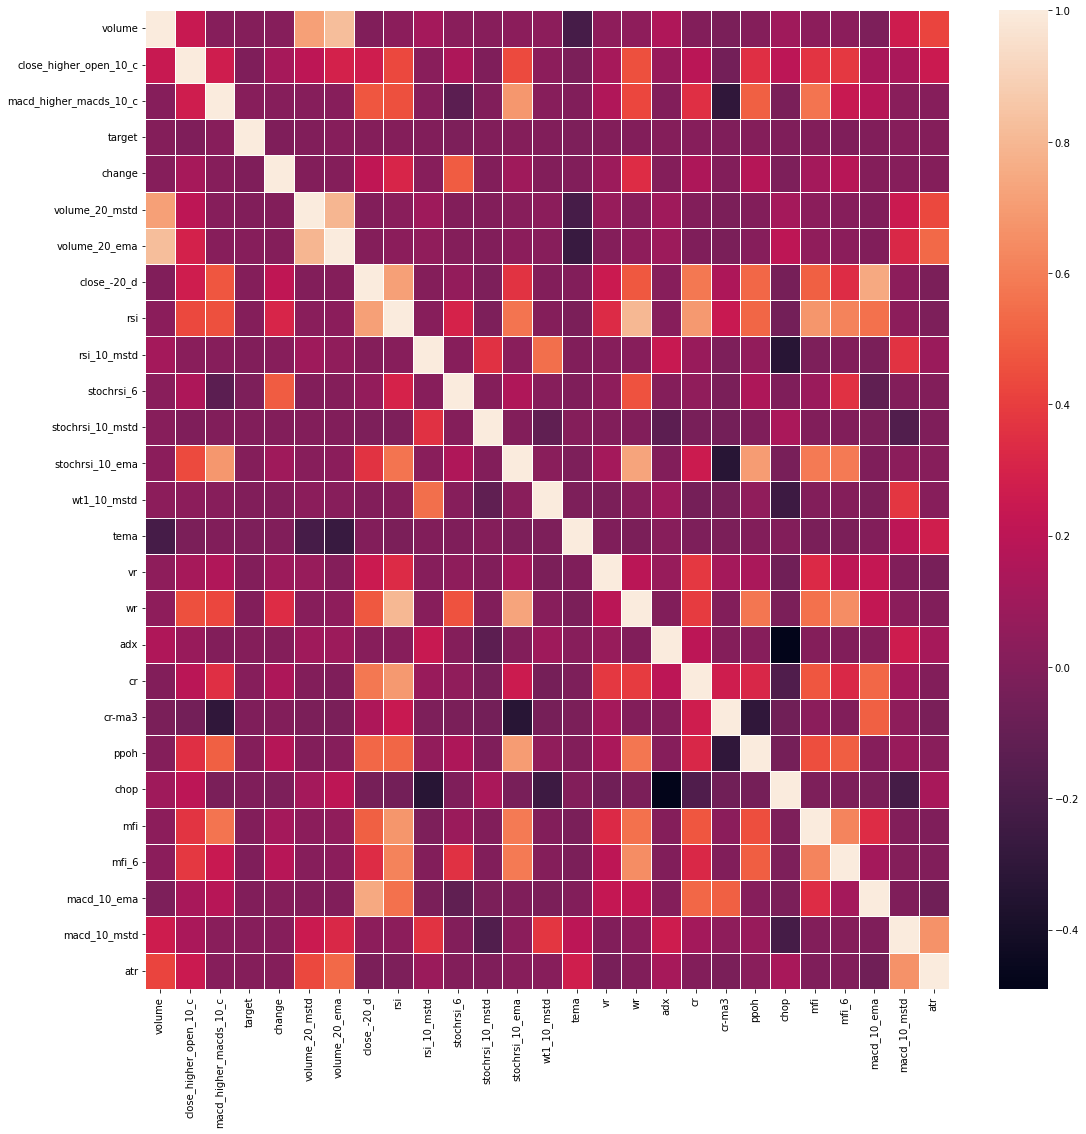

In [247]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train_preprocessed_df.corr(), linewidths=.5, fmt='.1f', ax=ax)

In [248]:
(train_preprocessed_df == np.inf).sum()

volume                    0
close_higher_open_10_c    0
macd_higher_macds_10_c    0
target                    0
change                    0
volume_20_mstd            0
volume_20_ema             0
close_-20_d               0
rsi                       0
rsi_10_mstd               0
stochrsi_6                0
stochrsi_10_mstd          0
stochrsi_10_ema           0
wt1_10_mstd               0
tema                      0
vr                        0
wr                        0
adx                       0
cr                        0
cr-ma3                    0
ppoh                      0
chop                      0
mfi                       0
mfi_6                     0
macd_10_ema               0
macd_10_mstd              0
atr                       0
dtype: int64

In [249]:
X_train = train_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_train = train_preprocessed_df["target"].to_numpy()

X_test = test_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_test = test_preprocessed_df["target"].to_numpy()

X_train.shape, X_test.shape

((236390, 26), (59090, 26))

In [250]:
scaler = StandardScaler()
regression = LinearRegression()
regression.fit(scaler.fit_transform(X_train), y_train)

regression_predictions = regression.predict(scaler.transform(X_test))
mean_squared_error(y_test, regression_predictions)

24.513297732514122

In [251]:
std = regression_predictions.std()
order_threshold = np.sqrt(std ** 2 / 0.2)

In [252]:
class_predictions = np.zeros(len(y_test))
class_predictions[regression_predictions > order_threshold] = 1
class_predictions[regression_predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[11936,    30,    67],
       [22972,   415,   321],
       [22420,   541,   388]], dtype=int64)

In [255]:
best_lgbm_params = study.best_params

In [256]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)

lgbm_regressor.fit(X_train, y_train)

lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

24.55360945138506

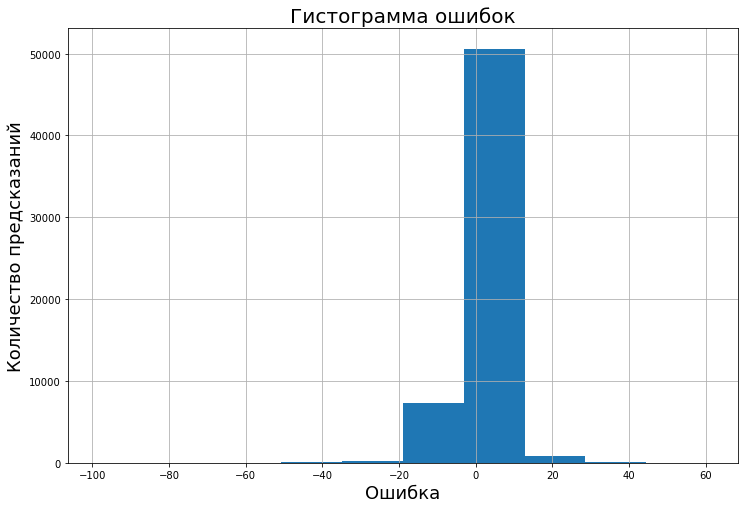

In [257]:
plt.figure(figsize=(12, 8))

plt.hist(y_test - lgbm_predictions)
plt.title("Гистограмма ошибок", fontsize=20)

plt.xlabel("Ошибка", fontsize=18)
plt.ylabel("Количество предсказаний", fontsize=18)

plt.grid()
plt.show()

In [258]:
lgbm_predictions

array([ 0.00367988,  0.00661623, -0.00728692, ..., -0.04586334,
       -0.03316223, -0.03880464])

In [259]:
std = lgbm_predictions.std()
order_threshold = np.sqrt(std ** 2 / 0.2)

In [260]:
class_predictions = np.zeros(len(y_test))
class_predictions[lgbm_predictions > order_threshold] = 1
class_predictions[lgbm_predictions < -order_threshold] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > order_threshold] = 1
true_classes[y_test < -order_threshold] = 2

confusion_matrix(true_classes, class_predictions)

array([[ 7969,     7,    16],
       [25020,   398,   242],
       [24298,   511,   629]], dtype=int64)

In [261]:
data = prepare_dataset(DATA_PATH)
data_preprocessed = get_features(data, train=True).reset_index(drop=True).dropna()
data_preprocessed

,volume,close_higher_open_10_c,macd_higher_macds_10_c,target,change,volume_20_mstd,volume_20_ema,close_-20_d,rsi,rsi_10_mstd,stochrsi_6,stochrsi_10_mstd,stochrsi_10_ema,wt1_10_mstd,tema,vr,wr,adx,cr,cr-ma3,ppoh,chop,mfi,mfi_6,macd_10_ema,macd_10_mstd,atr
5,4920.0,3.0,1.0,0.9120,-0.100402,12124.079621,18015.343946,0.00,40.406547,25.020398,77.671053,13.675364,89.363063,28.640306,159.220505,43.691581,-48.795181,100.000000,61.481481,200.000000,-0.000494,31.431617,0.500000,0.500000,-0.005984,0.004892,0.261486
6,3170.0,4.0,2.0,0.9240,0.113065,12494.728555,15208.456855,0.00,51.719224,26.252400,100.000000,11.165888,93.639041,35.075846,159.336965,47.792619,-21.686747,83.089459,75.746799,200.000000,0.003041,35.977586,0.500000,0.149187,-0.004439,0.004944,0.249576
7,3885.0,5.0,3.0,0.8000,0.012549,12375.148033,13251.140440,0.00,52.791554,26.366605,100.000000,9.669943,95.734693,42.467345,159.397303,52.818655,-18.674699,69.828240,84.779516,200.000000,0.005086,36.416668,0.500000,0.207780,-0.002008,0.005923,0.212912
8,6960.0,6.0,4.0,0.3320,0.106650,11864.695793,12242.010751,0.00,60.767833,27.041797,100.000000,8.649060,96.959147,50.203740,159.539069,61.822827,-0.000000,50.270377,103.129445,200.000000,0.009880,37.418555,0.500000,0.379540,0.002479,0.009104,0.206615
9,3190.0,6.0,5.0,0.2520,-0.043868,11687.455823,10878.856366,0.00,56.532273,26.587059,72.235703,7.838930,95.938594,55.537816,159.541666,59.372573,-10.364146,37.236027,101.016260,200.000000,0.010050,38.648996,0.500000,0.759798,0.006897,0.011492,0.188517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295524,1946.0,3.0,5.0,10.4000,-0.061858,759.978815,1530.398486,-2.89,39.696559,4.996065,0.000000,33.407704,44.987384,8.172170,953.452118,109.041104,-95.890411,23.885487,97.935837,106.507036,-0.015292,39.622457,0.353684,0.300141,-0.051750,0.076476,0.691300
295525,6061.0,2.0,4.0,9.9567,-0.099663,1262.966619,1961.884344,-2.75,35.678552,6.403776,0.000000,36.982137,36.807860,10.705209,952.409187,76.311589,-100.000000,31.126692,91.773548,103.525531,-0.027584,32.314240,0.290301,0.127842,-0.112137,0.131090,0.744065
295526,3270.0,3.0,3.0,8.2700,0.206876,1306.749366,2086.466788,0.23,47.537230,6.160455,63.499281,35.755957,40.977212,12.329313,953.416981,84.637650,-44.389027,29.551950,85.266612,101.417493,-0.020558,38.299934,0.343927,0.262377,-0.158267,0.153311,0.867346
295527,1720.0,4.0,3.0,12.0099,-0.107940,1289.965869,2051.565189,-0.10,43.066526,6.239354,57.636519,35.471860,40.293659,14.219122,953.200859,77.427863,-70.074813,28.427134,79.479359,100.539723,-0.021803,40.366183,0.331459,0.190488,-0.207624,0.179770,0.884678


In [262]:
X = data_preprocessed.drop(["target"], axis=1)
y = data_preprocessed["target"]

In [263]:
lgbm_regressor = LGBMRegressor(random_state=0, **best_lgbm_params)
lgbm_regressor.fit(X, y)
lgbm_regressor.booster_.save_model(MODEL_PATH)